Here we build an interactive map and html table of data science jobs across Germany.
We are using one of the job posting datasets that we collect weekly by using the [Adzuna API](https://developer.adzuna.com/) through **GitHub Actions**. The full script is available on my [GitHub Repository](https://github.com/Flazoukie/adzuna-scraper).
We collected data science-related job postings in Germany by filtering:

* Keyword = "data science"
* country or region (e.g., "de")
* pages = 5
* results_per_page = 100

## Requirements

In [1]:
# 📦 Core Libraries
import os
from glob import glob
import time
import ast
import re

# 🔢 Data Handling & Math
import json
import numpy as np
import pandas as pd

# 📊 Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from IPython.display import display, HTML
from IPython.display import IFrame

# 🗺️ Mapping, Geocoding & Clustering
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import MarkerCluster
from folium import IFrame

In [2]:
os.makedirs("output", exist_ok=True)

## 📁 Get the Data

We load the last data from Adzuna in the following steps:

* Search for all CSV files in the data/ folder whose filenames start with "jobs_", e.g., "jobs_2024-06-01.csv".
* Sort them in reverse (latest first).
* Load the most recent one

In [19]:
print("Current directory:", os.getcwd())
print("Files in data folder:", os.listdir("data"))

data_files = sorted(glob("data/jobs_*.csv"), reverse=True)

if data_files:
    latest_file = data_files[0]
    print(f"Using latest file: {latest_file}")
    
    try:
        # Add defensive options
        df = pd.read_csv(latest_file, encoding='utf-8', engine='python', on_bad_lines='skip')
        print(f"Loaded DataFrame with {df.shape[0]} rows and {df.shape[1]} columns")
    except Exception as e:
        print(f"Error reading CSV: {e}")
        with open(latest_file, 'r') as f:
            lines = f.readlines()
            print("First 10 lines of file:")
            print(''.join(lines[:10]))
        raise
else:
    raise FileNotFoundError("No CSV files found in the data/ directory.")


Using latest file: data\jobs_2025-06-16.csv
Loaded DataFrame with 250 rows and 17 columns


## 🧹 Clean Data

In [4]:
# Basic cleaning

# extract display name from the location (contains city and state)
def safe_extract_display_name(val):
    try:
        parsed = ast.literal_eval(val)
        return parsed.get("display_name")
    except:
        return val  # If not a dict string, keep the raw string like "Dresden"

df["location"] = df["location"].apply(lambda x: safe_extract_display_name(x) if pd.notna(x) else None)
df["company"] = df["company"].apply(lambda x: safe_extract_display_name(x) if pd.notna(x) else None)
df["title"] = df["title"].fillna("Unknown")

# drop duplicates based on job title, company, and location
df = df.drop_duplicates(subset=["title", "company", "location"])

# Keep only needed columns
cols_to_keep = [
    "id", "title", "company", "location", "latitude", "longitude", 
    "created", "redirect_url"
]
df = df[cols_to_keep].copy()

# Assign unique ID for merging later
df = df.reset_index(drop=True)
df["job_id"] = df.index

## 🌎 Get City Names by Using the Coordinates

Location descriptions can sometimes be imprecise or contain typos, or refer to smaller districts rather than the main city (for example, “Bilk” instead of “Düsseldorf”), which can cause errors in visualization. Instead of extracting all cities from the location description, we decided to use the coordinate provided in the dataset (when available) or calculate them.

For entries with coordinates:
* We perform **reverse geocoding** on the coordinates to find the corresponding city names.
* To avoid redundant API calls and speed up future runs, we implement a **local cache** stored in a JSON file.

For entries missing latitude or longitude:
* We attempt to extract a city name from a string-based location field
* We then geocode these city names to recover their latitude and longitude coordinates.
* These recovered coordinates are merged back into the main DataFrame to fill missing values.

In [5]:
# geocode city name from longitude and latitude and build chache

# 🧭 Setup geolocator
geolocator = Nominatim(user_agent="adzuna-geocoder")

# Load cache file if exists, else create empty dict
CACHE_FILE = "coord_to_city_cache.json"
if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "r") as f:
        coord_to_city = json.load(f)
else:
    coord_to_city = {}

def get_city_from_coords(lat, lon, pause=1.1):
    key = f"{lat},{lon}"
    if key in coord_to_city:
        return coord_to_city[key]

    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, language="en")
        if location is None:
            city = None
        else:
            address = location.raw.get("address", {})
            city = (
                address.get("city") or 
                address.get("town") or 
                address.get("village") or 
                address.get("municipality") or 
                address.get("county") or 
                address.get("state")
            )
        coord_to_city[key] = city
        time.sleep(pause)
        return city
    except Exception as e:
        print(f"Error reverse geocoding {lat}, {lon}: {e}")
        return None

# Prepare unique coordinates from df
df_coords = df.dropna(subset=["latitude", "longitude"]).copy()
unique_coords = df_coords[["latitude", "longitude"]].drop_duplicates()

# Reverse geocode with caching
for _, row in unique_coords.iterrows():
    lat, lon = row["latitude"], row["longitude"]
    get_city_from_coords(lat, lon)

# Assign city names back to df_coords using the cache
df_coords["city"] = df_coords.apply(
    lambda r: coord_to_city.get(f"{r['latitude']},{r['longitude']}"), axis=1
)

# Save cache to disk for next runs
with open(CACHE_FILE, "w") as f:
    json.dump(coord_to_city, f)

In [6]:
# 🧭 Geocode missing coordinates from location string

def extract_city_from_location(location):
    if pd.isna(location):
        return None
    if isinstance(location, str):
        try:
            location_dict = ast.literal_eval(location)
            area = location_dict.get("area", [])
            if isinstance(area, list) and area:
                return area[-1]
        except Exception:
            pass
    match = re.search(r"\b([A-ZÄÖÜ][a-zäöüßA-ZÄÖÜ-]+)", location)
    if match:
        return match.group(1)
    return None

missing_coords = df[df["latitude"].isna() | df["longitude"].isna()].copy()
missing_coords["recovered_city"] = missing_coords["location"].apply(extract_city_from_location)

# Filter out entries that are too broad
valid_city_mask = missing_coords["recovered_city"].notna() & (missing_coords["recovered_city"].str.lower() != "deutschland")
to_geocode = missing_coords[valid_city_mask].copy()

def geocode_city(city):
    try:
        if pd.isna(city):
            return (None, None)
        location = geolocator.geocode(f"{city}, Germany")
        if location:
            return (location.latitude, location.longitude)
    except GeocoderTimedOut:
        time.sleep(1)
        return geocode_city(city)  # retry once
    except Exception:
        return (None, None)
    return (None, None)

coords_df = to_geocode["recovered_city"].apply(lambda city: pd.Series(geocode_city(city)))
coords_df.columns = ["latitude_recovered", "longitude_recovered"]

to_geocode = to_geocode.reset_index(drop=True)
to_geocode = pd.concat([to_geocode, coords_df], axis=1)
to_geocode["job_id"] = to_geocode.index

# Drop previously added columns if they exist (avoid merge errors)
df = df.drop(columns=["latitude_recovered", "longitude_recovered"], errors="ignore")

# Merge recovered coordinates back into the main DataFrame
df = df.merge(to_geocode[["job_id", "latitude_recovered", "longitude_recovered"]], on="job_id", how="left")

# Fill missing lat/lon with recovered values
df["latitude"] = df["latitude"].fillna(df["latitude_recovered"])
df["longitude"] = df["longitude"].fillna(df["longitude_recovered"])

# Final cleanup
df = df.drop(columns=["latitude_recovered", "longitude_recovered"])

## 🔝 Top Cities for Job Offers

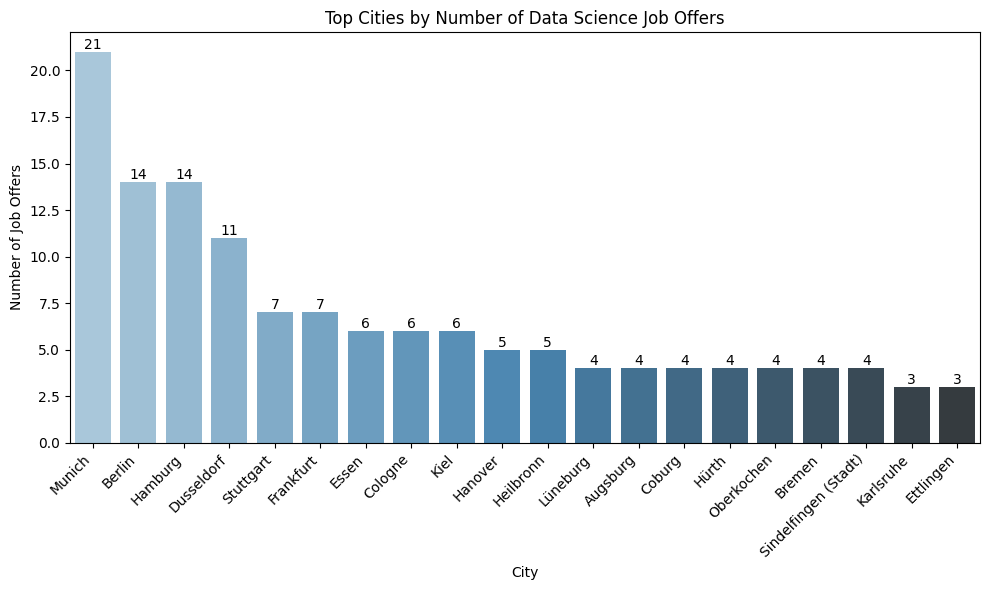

In [7]:
## Top 20 Cities for Job Offers

top_cities = df_coords["city"].value_counts().head(20).reset_index() # get top 20
top_cities.columns = ["city", "count"]

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_cities, x="city", y="count", palette="Blues_d", hue="city", legend=False)

# Add annotations
for i, row in top_cities.iterrows():
    ax.text(i, row["count"], str(row["count"]), ha='center', va='bottom', fontsize=10)

plt.title("Top Cities by Number of Data Science Job Offers")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Number of Job Offers")
plt.tight_layout()
plt.show()

In [8]:
# save output
plt.savefig("output/top_cities.png", bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## 🗺️ Mapping Job Clusters and Top Hiring Companies in Germany
To visualize where data science jobs are concentrated across Germany, we used the geographical coordinates provided in the dataset (latitude and longitude) and applied the algorithm **DBSCAN** to create clusters. This allowed us to group nearby job postings within a 10 km radius into location-based clusters.

For each cluster, we:

* Calculated the average coordinates to place a marker on the map.
* Counted the number of job postings and identified the top 10 hiring companies in each cluster.

We then used the **Folium library** to create an interactive map. Each marker on the map displays:

* The name of the city (based on the reverse-geocoded coordinates)
* The top companies hiring in that location
* The number of job postings per company (e.g., “Company XYZ (3)”)

This approach helps identify regional hiring trends and hotspots for data science roles in Germany.

In [9]:
# Run DBSCAN clustering

# since DBSCAN needs the eps in radians, not kilometers and Earth's radius is approximately 6371 km
# we divide 10 km by that value to convert it to radians.
coords = df_coords[['latitude', 'longitude']].values
kms_per_radian = 6371.0088
epsilon = 10 / kms_per_radian  # 10 km radius

# initialize DBSCAN clustering algorithm:
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
df_coords['cluster'] = db.fit_predict(np.radians(coords))

# Assign representative city name to each cluster (city with most jobs)
cluster_names = (
    df_coords.groupby('cluster')['city']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    .reset_index()
)

df_coords = df_coords.merge(cluster_names, on='cluster', suffixes=('', '_clustered'))
df_coords['city'] = df_coords['city_clustered']
df_coords.drop(columns='city_clustered', inplace=True)

df_coords = df_coords.drop(columns='cluster_city', errors='ignore')  # if it existed

# Summarize clusters with mean coordinates and job counts
cluster_summary = (
    df_coords.groupby(['cluster', 'city'])
    .agg({
        'latitude': 'mean',
        'longitude': 'mean',
        'title': 'count'
    })
    .reset_index()
    .rename(columns={'title': 'job_count'})
)


# Prepare top companies per cluster (will popup when clicking)
top_companies_per_cluster = (
    df_coords.groupby(['cluster', 'company'])
    .size()
    .reset_index(name='job_count')
    .sort_values(['cluster', 'job_count'], ascending=[True, False])
    .groupby('cluster', group_keys=False)
    .head(10)
)

popup_data = top_companies_per_cluster.merge(
    cluster_summary[['cluster', 'city', 'latitude', 'longitude']],
    on='cluster'
)


# Create map with company popups
map_center = [51.1657, 10.4515]  # Germany center
company_map = folium.Map(location=map_center, zoom_start=6)
marker_cluster = MarkerCluster().add_to(company_map)

for cluster_id, group in popup_data.groupby('cluster'):
    city = group['city'].iloc[0]
    lat = group['latitude'].iloc[0]
    lon = group['longitude'].iloc[0]

    companies_html = '<br>'.join(
    f"{row['company']} ({row['job_count']})" for _, row in group.iterrows()
    )
    html = f"""
    <h4>{city}</h4>
    <div style="font-family: Arial; font-size: 12px;">
    {companies_html}
    </div>
    """
    iframe = IFrame(html=html, width=300, height=150)
    popup = folium.Popup(iframe, max_width=300)

    folium.Marker(
        location=[lat, lon],
        popup=popup,
        tooltip=city
    ).add_to(marker_cluster)

display(company_map)


# Add map note for reader
display(HTML("""
<p style="font-family: Arial; font-size: 14px; margin-top: 10px;">
<b>Note:</b> The numbers on the map markers represent how many job locations are clustered together in that area.
Zoom in to explore individual job locations and click on them to view the top hiring companies in that region
and the number of jobs per each company. The city names are in English!
</p>
"""))


In [10]:
#Save map
company_map.save("output/company_map.html")

## 📊 Interactive Company & Job Title Chart per City

In [11]:
# Aggregate job data
table_data = (
    df_coords
    .groupby(['city', 'company'])  
    .agg(
        job_titles=('title', list),
        job_links=('redirect_url', list),
        job_dates=('created', list),
        latest_date=('created', lambda dates: max(pd.to_datetime(dates)))  # For sorting
    )
    .reset_index()
)


# Format job titles + links + dates into HTML and sort by published date
def format_job_entry(title, link, date):
    raw_date = pd.to_datetime(date)
    display_date = raw_date.strftime('%d-%m-%Y')  # EU format
    return (
        f"{title}<br>"
        f"<a href='{link}' target='_blank'>🔗 Link</a><br>"
        f"<em>date: {display_date}</em>"
    )

table_data['jobs'] = table_data.apply(
    lambda row: '<br><br>'.join(
        format_job_entry(t, l, d)
        for t, l, d in zip(row['job_titles'], row['job_links'], row['job_dates'])
    ),
    axis=1
)

# Step 3: Final table with renamed columns (include SortDate as hidden column)
table_data_display = table_data[['city', 'company', 'jobs', 'latest_date']].rename(columns={
    'city': 'City',
    'company': 'Company',
    'jobs': 'Job Offers',
    'latest_date': 'SortDate'
})




# Fix date format for sorting
table_data['latest_date'] = pd.to_datetime(table_data['latest_date']).dt.strftime('%Y-%m-%d')

# Final table with sorting column
table_data_display = table_data[['city', 'company', 'jobs', 'latest_date']].rename(columns={
    'city': 'City',
    'company': 'Company',
    'jobs': 'Job Offers',
    'latest_date': 'SortDate'
})

# HTML table
html_table = table_data_display.to_html(
    escape=False, index=False, classes='display', table_id='jobTable'
)

# HTML Template
html_template = f"""
<html>
<head>
<meta charset="utf-8">
<title>Job Offers Interactive Table</title>
<link rel="stylesheet" type="text/css" href="https://cdn.datatables.net/1.13.6/css/jquery.dataTables.css">
<script src="https://code.jquery.com/jquery-3.7.0.js"></script>
<script src="https://cdn.datatables.net/1.13.6/js/jquery.dataTables.js"></script>
<style>
  body {{
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    background-color: #fafafa;
    padding: 20px;
  }}

  h2 {{
    color: #333;
  }}

  p {{
    margin-bottom: 10px;
    font-size: 0.95em;
    color: #555;
  }}

  #cityFilter {{
    margin-bottom: 20px;
    font-size: 1em;
  }}

  table.dataTable {{
    border-collapse: collapse !important;
    width: 100%;
    background-color: white;
    overflow: hidden;
    box-shadow: 0 2px 10px rgba(0,0,0,0.05);
  }}

  table.dataTable thead {{
    background-color: #333;
    color: white;
  }}

  table.dataTable th,
  table.dataTable td {{
    padding: 10px;
    text-align: left;
    vertical-align: top;
    white-space: normal;
  }}

  table.dataTable tbody tr:nth-child(odd) {{
    background-color: #f9f9f9;
  }}

  table.dataTable tbody tr:hover {{
    background-color: #eef2f7;
    transition: background-color 0.2s ease;
  }}

  a {{
    color: #1a73e8;
    text-decoration: none;
  }}

  a:hover {{
    text-decoration: underline;
  }}
</style>
</head>
<body>

<h2>Data Science Job Offers by City and Company</h2>
<p>Use the dropdown to filter by city or the search box to filter by keywords. Click the 🔗 link to view or apply for a job.</p>

<label for="cityFilter"><strong>Filter by City:</strong></label>
<select id="cityFilter">
  <option value="">All Cities</option>
</select>

{html_table}

<script>
$(document).ready(function() {{
    var table = $('#jobTable').DataTable({{
        "pageLength": 10,
        "lengthMenu": [5, 10, 20, 50],
        "order": [[3, 'desc']],
        "columnDefs": [
            {{
                "targets": 3,
                "visible": false,
                "searchable": false
            }}
        ]
    }});

    // Populate City filter dropdown
    var uniqueCities = table.column(0).data().unique().sort();
    uniqueCities.toArray().forEach(function(city) {{
        $('#cityFilter').append(`<option value="${{city}}">${{city}}</option>`);
    }});

    // Filter table by selected city
    $('#cityFilter').on('change', function() {{
        var selected = $(this).val();
        if (selected) {{
            table.column(0).search('^' + selected + '$', true, false).draw();
        }} else {{
            table.column(0).search('').draw();
        }}
    }});
}});
</script>

</body>
</html>
"""

In [12]:
# save interactive table for allowing display on my quarto blog
with open("output/interactive_job_table.html", "w", encoding="utf-8") as f:
    f.write(html_template)

In [16]:
# display
# Display iframe loading the same file with correct path
IFrame(src='output/interactive_job_table.html', width='90%', height=600)